<a href="https://colab.research.google.com/github/rayxuan2000/Project/blob/main/Stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction RNN

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs such as vanishing/exploding gradient.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [179]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# https://drive.google.com/file/d/1cXatOm74yzby2k-B0u8w4cGDCprMS9qp/view?usp=sharing

id = "1cXatOm74yzby2k-B0u8w4cGDCprMS9qp"
file = drive.CreateFile({'id':id})
file.GetContentFile('all_stocks_5yr.csv')

In [180]:
# Importing the training set
dataset = pd.read_csv('all_stocks_5yr.csv')

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [181]:
dataset.head(10)

,date,open,high,low,close,volume,Name
0,2013/2/8,15.07,15.12,14.63,14.75,8407500,AAL
1,2013/2/11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013/2/12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013/2/13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013/2/14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013/2/15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013/2/19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013/2/20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013/2/21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013/2/22,13.57,13.60,13.21,13.57,6071400,AAL


In [182]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [183]:
dataset['Name'].value_counts()

AAL     1259
NRG     1259
NOC     1259
NLSN    1259
NKE     1259
        ... 
DXC      215
BHGE     152
BHF      143
DWDP     109
APTV      44
Name: Name, Length: 505, dtype: int64

In [184]:
dataset[dataset['Name']=='SWKS']

,date,open,high,low,close,volume,Name
524591,2013/2/8,23.87,24.31,23.870,23.93,2522548,SWKS
524592,2013/2/11,23.87,24.34,23.730,24.25,2387664,SWKS
524593,2013/2/12,24.14,24.50,24.030,24.20,2991270,SWKS
524594,2013/2/13,24.21,24.50,24.060,24.30,2684874,SWKS
524595,2013/2/14,24.12,25.04,24.100,24.97,4413204,SWKS
...,...,...,...,...,...,...,...
525845,2018/2/1,98.54,103.91,98.500,103.15,5172360,SWKS
525846,2018/2/2,102.28,102.49,98.930,98.96,3767699,SWKS
525847,2018/2/5,97.95,99.72,94.331,94.68,5451830,SWKS
525848,2018/2/6,101.05,106.74,100.750,104.56,8628644,SWKS


In [185]:
dataset_cl = dataset[dataset['Name']=='SWKS'].close.values
dataset_cl

array([ 23.93,  24.25,  24.2 , ...,  94.68, 104.56, 101.35])

In [186]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)
dataset_cl

array([[0.03930131],
       [0.04262841],
       [0.04210855],
       ...,
       [0.77490123],
       [0.87762529],
       [0.84425036]])

## Step 2:  Cutting time series into sequences (Sliding Window)

Time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}(p=1,2,...,P)$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs (each row represents one pair).  More generally, for a window size T we create P - T such pairs.

Now window the input time series as described above.

In [187]:
input_size = 7
# Create a function to process the data into 7 day look back slices
# lb is window size
def processData(data, lb):
    X, y = [], [] # X is input vector, Y is output vector
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        y.append(data[(i + lb), 0])
    return np.array(X), np.array(y)

X, y = processData(dataset_cl, input_size)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [188]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


In [189]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, I can now begin setting up RNN.  I build a RNN of the following specifications

- Layer 1 uses an LSTM module with 7 hidden units (note here the input_shape = (window_size,1))
- Layer 2 uses a fully connected module with one unit
- The 'mean_squared_error' loss should be used

In [190]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=False):
        super().__init__()
        # super(RNN, self).__init__()

        self.num_directions = bidirectional + 1

        # LSTM module
        self.rnn = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional
        )

        # Output layer
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)

        # Convert dimension of r_out (-1 denotes it depends on other parameters)
        r_out = r_out.view(-1, self.num_directions, hidden_size)

        outs = self.out(r_out)

        return outs, hidden_state

In [191]:
# Globals
INPUT_SIZE = input_size # LSTM input size
# HIDDEN_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 3 # LSTM stack layer
OUTPUT_SIZE = 1
# BATCH_SIZE = 128

# Hyper parameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [192]:
rnn

RNN(
  (rnn): LSTM(7, 128, num_layers=3, dropout=0.1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [193]:
# Train_ds=StockDataset(X_train, y_train)

In [168]:
history = [] # save loss in each epoch
# .cuda() copies element to the GPU memory
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# Use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

# training
for epoch in range(num_epochs):

    # Train mode
    rnn.train()

    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()   # back propagation
    optimiser.step()   # update the parameters

    if epoch % 20 == 0:
        # Convert train mode to evaluation mode (disable dropout)
        rnn.eval()

        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.3290722072124481, eval loss 0.8072199821472168
epoch 1, loss 0.2831905484199524
epoch 2, loss 0.23946832120418549
epoch 3, loss 0.19529218971729279
epoch 4, loss 0.14784905314445496
epoch 5, loss 0.0971883162856102
epoch 6, loss 0.051626596599817276
epoch 7, loss 0.055053338408470154
epoch 8, loss 0.0877162292599678
epoch 9, loss 0.05892035365104675
epoch 10, loss 0.04050785303115845
epoch 11, loss 0.03932986408472061
epoch 12, loss 0.04494355246424675
epoch 13, loss 0.048406124114990234
epoch 14, loss 0.049362387508153915
epoch 15, loss 0.046519674360752106
epoch 16, loss 0.039930809289216995
epoch 17, loss 0.031190313398838043
epoch 18, loss 0.023160051554441452
epoch 19, loss 0.017967650666832924
epoch 20, loss 0.022462962195277214, eval loss 0.02038823440670967
epoch 21, loss 0.02744702622294426
epoch 22, loss 0.021333282813429832
epoch 23, loss 0.012848754413425922
epoch 24, loss 0.011115994304418564
epoch 25, loss 0.013118711300194263
epoch 26, loss 0.014685481786

In [169]:
rnn.out.weight

Parameter containing:
tensor([[-0.0812,  0.0088,  0.0168, -0.0364,  0.0298,  0.0610,  0.0672,  0.0223,
          0.0309, -0.0225, -0.0146,  0.0348,  0.0133,  0.0505, -0.0360,  0.0791,
         -0.0492,  0.0191,  0.0768,  0.0445, -0.0323, -0.0482,  0.0147,  0.0539,
          0.0805, -0.0805,  0.0366, -0.0722, -0.0066, -0.0861,  0.0318, -0.0164,
         -0.0658,  0.0830,  0.0258, -0.0491,  0.0700, -0.0420, -0.0502,  0.0462,
         -0.0528, -0.0764, -0.0650,  0.0136, -0.0566, -0.0523,  0.0324,  0.0011,
         -0.0384, -0.0302, -0.0259, -0.0392,  0.0463, -0.0417, -0.0629, -0.0085,
         -0.0651, -0.0762, -0.0389,  0.0318, -0.0080,  0.0044, -0.0434, -0.0012,
          0.0449,  0.0680,  0.0517,  0.0265, -0.0584,  0.0807, -0.0045,  0.0074,
          0.0345, -0.0701,  0.0824,  0.0319, -0.0889,  0.0120,  0.0204, -0.0655,
          0.0256,  0.0768,  0.0593, -0.0200,  0.0105,  0.0327, -0.0892, -0.0068,
          0.0792,  0.0310,  0.0123,  0.0629,  0.0226, -0.0707,  0.0049, -0.0494,
      

In [170]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0420,  0.0639, -0.0657,  ...,  0.0650, -0.0484,  0.0222],
        [-0.1075, -0.0623,  0.0504,  ...,  0.0147, -0.0985, -0.0114],
        [-0.0485,  0.0045,  0.0075,  ...,  0.0303, -0.0805, -0.0612],
        ...,
        [ 0.0683,  0.0160,  0.0947,  ...,  0.0537,  0.1089,  0.0836],
        [-0.0775,  0.0308, -0.0659,  ..., -0.0458,  0.0359,  0.0419],
        [-0.0549,  0.0439,  0.0524,  ..., -0.0678,  0.0012,  0.0633]],
       device='cuda:0')
tensor([[-0.0616,  0.0802, -0.0745,  ...,  0.0779,  0.0112, -0.0458],
        [-0.0293,  0.0538, -0.0416,  ..., -0.0543,  0.0325, -0.1142],
        [-0.0715,  0.0009, -0.0685,  ..., -0.0328,  0.0146, -0.0098],
        ...,
        [-0.0630,  0.0055,  0.0069,  ...,  0.0102, -0.0303, -0.0240],
        [ 0.0642, -0.0100,  0.0187,  ..., -0.1257,  0.0442,  0.0456],
        [ 0.0448,  0.0093, -0.0047,  ...,  0.0116, -0.0518,  0.0469]],
       device='cuda:0')
tensor([-0.0030,  0.0006, -0.0343,  0.0282, -0.0759,  0.0133,  0.0063,  0.0008,
    

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

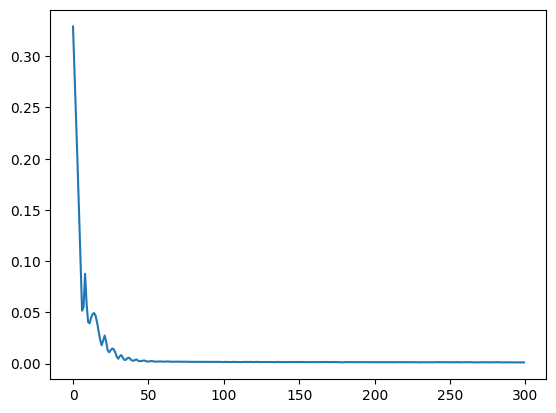

In [171]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [172]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [173]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [174]:
test_predict_cpu.shape

(251, 1, 1)

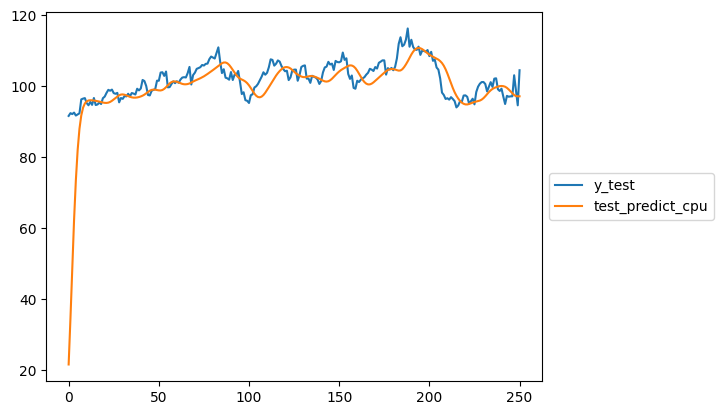

In [175]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.legend(['y_test','test_predict_cpu'], loc='center left', bbox_to_anchor=(1, 0.5))

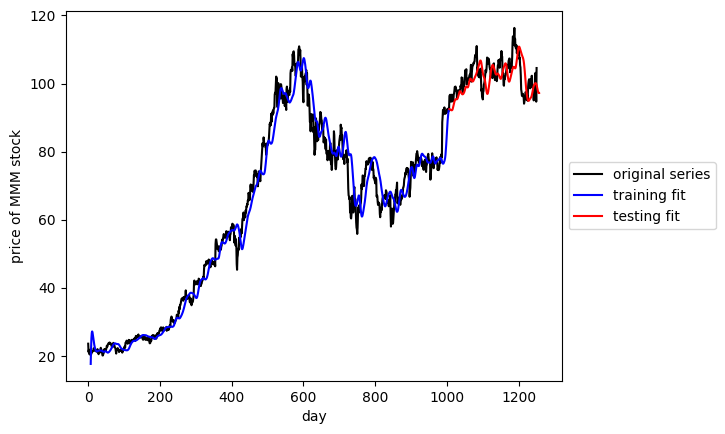

In [176]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [177]:
MMSE = np.sum((test_predict_cpu.reshape(1,X_test.shape[0])-y[1000:])**2)/X_test.shape[0]
print(MMSE)

0.0011194465161525537
